# Project 2 Computer Vision CS-GY 6643
Team Members:
- Diego Rosenebrg (dr3432)
- Thiago Viegas (tjv235)


## Question 5

We will keep the original model (provided to us by the TAs) as a sanity check and a base resource to base ourselves off of. We will begin our own improved version of this in the "Team Model" subsection below.

## General Q5 Utils

In [1]:
# Get google colab private keys
import os
import json
kaggle_username = "thiagoviegas"
api_key = 'u448f2b461e97726c5f1ed288915f721a' # Make sure to have KAGGLE_API name in google colab secret keys

# Dictionary of username, and key
kaggle_dict = {'username': kaggle_username, 'key': api_key}

# Check if "~/.kaggle/" folder exists
if not os.path.exists(os.path.expanduser("~/.kaggle")):
    os.makedirs(os.path.expanduser("~/.kaggle"))

# Save kaggle_dict to "~/.kaggle/kaggle.json"
with open(os.path.expanduser("~/.kaggle/kaggle.json"), 'w') as f:
    json.dump(kaggle_dict, f)

# chmod 600 the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c cell-segmentation-cs-gy-6643


cell-segmentation-cs-gy-6643.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!pip3 install cv2-python numpy matplotlib pandas seaborn scikit-learn tqdm albumentations==0.4.6 segmentation-models-pytorch==0.2.1 torchinfo

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try brew install
    xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a Python library that isn't in Homebrew,
    use a virtual environment:
    
    python3 -m venv path/to/venv
    source path/to/venv/bin/activate
    python3 -m pip install xyz
    
    If you wish to install a Python application that isn't in Homebrew,
    it may be easiest to use 'pipx install xyz', which will manage a
    virtual environment for you. You can install pipx with
    
    brew install pipx
    
    You may restore the old behavior of pip by passing
    the '--break-system-packages' flag to pip, or by adding
    'break-system-packages = true' to your pip.conf file. The latter
    will permanently disable this error.
    
    If you disable this error, we STRONGLY recommend that you additionally
    pass the '--user' flag to pip, or set 

In [ ]:
!kaggle competitions list | head


ref                                                                                 deadline             category                reward  teamCount  userHasEntered  
----------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/arc-prize-2025                                  2025-11-03 23:59:00  Featured         1,000,000 Usd       1344           False  
https://www.kaggle.com/competitions/hull-tactical-market-prediction                 2025-12-15 23:59:00  Featured           100,000 Usd       1511           False  
https://www.kaggle.com/competitions/google-code-golf-2025                           2025-10-30 23:59:00  Research           100,000 Usd       1123           False  
https://www.kaggle.com/competitions/recodai-luc-scientific-image-forgery-detection  2026-01-15 23:59:00  Research            55,000 Usd        162           False  
https://ww

In [ ]:
!ls -lh /content


total 312M
-rw-r--r-- 1 root root 312M Oct 18 00:23 cell-segmentation-cs-gy-6643.zip
drwxr-xr-x 4 root root 4.0K Oct 28 14:05 data_folder
drwxr-xr-x 1 root root 4.0K Oct 24 13:37 sample_data


In [ ]:
# Unzip the competition archive again into data_folder/
!unzip -q cell-segmentation-cs-gy-6643.zip -d data_folder

# Quick check: list top-level contents
!ls -lh data_folder


replace data_folder/test_final/slide1.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
total 11M
drwxr-xr-x 2 root root 4.0K Oct 28 14:07 test_final
drwxr-xr-x 2 root root  20K Oct 28 14:07 train
-rw-r--r-- 1 root root  11M Oct 18 00:23 train_ground_truth.csv


In [4]:
import os, cv2, math, xml.etree.ElementTree as ET
import numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from skimage import draw
from skimage.measure import label as cc_label
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# Paths (you already unzipped to data_folder)
BASE = Path("data_folder")
TRAIN_DIR = BASE / "train"
TEST_DIR  = BASE / "test_final"

CLASSES = ["Epithelial","Lymphocyte","Neutrophil","Macrophage"]
IMG_SIZE = 320        # small & fast; bump for quality
BATCH_SIZE = 4
EPOCHS = 3            # quick demo; bump to 15–30 for results
LR = 1e-3
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
print("Device:", DEVICE)


Device: mps


In [5]:
def parse_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    annotations = []

    for annotation in root.findall('Annotation'):
        cell_type = None
        attributes = annotation.find('Attributes')
        if attributes is not None:
            attribute = attributes.find('Attribute')
            if attribute is not None:
                cell_type = attribute.get('Name')

        if not cell_type:
            continue

        regions_element = annotation.find('Regions')
        if regions_element is not None:
            regions = regions_element.findall('Region')

            for region in regions:
                vertices = []
                vertices_element = region.find('Vertices')

                if vertices_element is not None:
                    for vertex in vertices_element.findall('Vertex'):
                        x = float(vertex.get('X'))
                        y = float(vertex.get('Y'))
                        vertices.append((x, y))

                if vertices:
                    annotations.append({
                        'cell_type': cell_type,
                        'vertices': vertices
                    })

    return annotations

def generate_masks(image_shape, annotations):
    height, width = image_shape[:2]

    masks = {
        'Epithelial': np.zeros((height, width), dtype=np.uint16),
        'Lymphocyte': np.zeros((height, width), dtype=np.uint16),
        'Neutrophil': np.zeros((height, width), dtype=np.uint16),
        'Macrophage': np.zeros((height, width), dtype=np.uint16)
    }

    instance_id = {
        'Epithelial': 1,
        'Lymphocyte': 1,
        'Neutrophil': 1,
        'Macrophage': 1
    }

    for ann in annotations:
        cell_type = ann['cell_type']
        if cell_type in masks:
            vertices = np.array(ann['vertices'])
            rr, cc = draw.polygon(vertices[:, 1], vertices[:, 0], shape=(height, width))
            masks[cell_type][rr, cc] = instance_id[cell_type]
            instance_id[cell_type] += 1

    return masks

def rle_encode(mask):
    pixels = mask.flatten(order="F").astype(np.int32)
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1

    rle_parts = []
    for i in range(len(runs)-1):
        start = runs[i]
        end = runs[i+1] if i+1 < len(runs) else len(pixels)-1
        length = end - start
        value = pixels[start]

        if value > 0:
            rle_parts.extend([value, start, length])

    return ' '.join(str(x) for x in rle_parts) if rle_parts else ""

def rle_decode(mask_rle, shape):
    if isinstance(mask_rle, float) and np.isnan(mask_rle):
        return np.zeros(shape, dtype=np.uint16)

    if not mask_rle or mask_rle.strip() == '':
        return np.zeros(shape, dtype=np.uint16)

    s = str(mask_rle).split()
    if len(s) == 0 or len(s) % 3 != 0:
        return np.zeros(shape, dtype=np.uint16)

    img = np.zeros(shape[0] * shape[1], dtype=np.uint16)

    for i in range(0, len(s), 3):
        value = int(s[i])
        start = int(s[i+1]) - 1
        length = int(s[i+2])
        img[start:start+length] = value

    return img.reshape(shape, order='F')


In [6]:
class CellDataset(Dataset):
    def __init__(self, data_dir, image_size=256):
        self.data_dir = Path(data_dir)
        self.image_size = image_size
        self.xml_files = list(self.data_dir.glob("*.xml"))

    def __len__(self):
        return len(self.xml_files)

    def __getitem__(self, idx):
        xml_path = self.xml_files[idx]
        img_path = xml_path.with_suffix('.tif')

        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_shape = image.shape[:2]
        annotations = parse_xml(xml_path)
        masks = generate_masks(original_shape, annotations)

        # Convert masks to a single 3D array
        mask = np.zeros((4, *original_shape), dtype=np.float32)
        for i, cell_type in enumerate(CLASSES):
            mask[i] = (masks[cell_type] > 0).astype(np.float32)

        # Random rotation angle from [0, 90, 180, 270]
        angle = random.choice([0, 90, 180, 270])
        image = np.rot90(image, k=angle // 90)
        mask = np.rot90(mask, k=angle // 90, axes=(1, 2))

        # Resize after rotation (if needed)
        image = cv2.resize(image, (self.image_size, self.image_size))
        mask = np.stack([
            cv2.resize(mask[i], (self.image_size, self.image_size))
            for i in range(mask.shape[0])
        ])

        # Normalize, permute, and convert to tensors
        image = image.astype(np.float32) / 255.0
        image = np.transpose(image, (2, 0, 1))

        return {
            'image': torch.from_numpy(image),
            'mask': torch.from_numpy(mask),
            'angle': angle,  # optional, for debugging
            'image_id': xml_path.stem,
        }

    """

    def __getitem__(self, idx):
        xml_path = self.xml_files[idx]
        img_path = xml_path.with_suffix('.tif')

        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_shape = image.shape[:2]
        image = cv2.resize(image, (self.image_size, self.image_size))

        annotations = parse_xml(xml_path)
        masks = generate_masks(original_shape, annotations)

        mask = np.zeros((4, self.image_size, self.image_size), dtype=np.float32)
        for i, cell_type in enumerate(CLASSES):
            cell_mask = masks[cell_type]
            binary_mask = (cell_mask > 0).astype(np.float32)
            binary_mask = cv2.resize(binary_mask, (self.image_size, self.image_size))
            mask[i] = binary_mask

        image = image.astype(np.float32) / 255.0
        image = np.transpose(image, (2, 0, 1))

        return {
            'image': torch.from_numpy(image),
            'mask': torch.from_numpy(mask),
            'image_id': xml_path.stem,
            'original_shape': original_shape
        } """





In [ ]:
def dice_loss(pred, target, smooth=1e-5):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) /
                 (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

In [ ]:
def predict_test_set(model, test_dir, device, threshold=0.5):
    model = model.to(device)
    model.eval()

    test_tif_files = list(Path(test_dir).glob("*.tif"))
    submission_rows = []

    print(f"\nPredicting on {len(test_tif_files)} test images...")

    with torch.no_grad():
        for tif_file in tqdm(test_tif_files):
            image = cv2.imread(str(tif_file))
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            original_shape = image_rgb.shape[:2]

            image_resized = cv2.resize(image_rgb, (IMG_SIZE, IMG_SIZE))
            image_norm = image_resized.astype(np.float32) / 255.0
            image_tensor = torch.from_numpy(np.transpose(image_norm, (2, 0, 1))).unsqueeze(0).to(device)

            output = model(image_tensor)
            output = output.squeeze(0).cpu().numpy()

            instance_masks = {}
            for i, cell_type in enumerate(CLASSES):
                mask = output[i]
                mask = cv2.resize(mask, (original_shape[1], original_shape[0]))
                binary_mask = (mask > threshold).astype(np.uint8)

                labeled_mask, _ = ndimage.label(binary_mask)
                instance_masks[cell_type] = labeled_mask.astype(np.uint16)

            image_id = tif_file.stem
            row = {'image_id': image_id}

            for cell_type in CLASSES:
                mask = instance_masks[cell_type]
                row[cell_type] = rle_encode(mask) if np.max(mask) > 0 else ""

                # If row[cell_type] is empty, add a 0
                if not row[cell_type]:
                    row[cell_type] = 0

            submission_rows.append(row)

    return pd.DataFrame(submission_rows)

In [ ]:
import torch.nn.functional as F

class Up(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        # upsample by 2 (no learnable kernel → smoother, no checkerboard)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        # after concat: (skip_ch + in_ch) → out_ch
        self.conv = DoubleConv(in_ch + skip_ch, out_ch)

    def forward(self, x, skip):
        x = self.up(x)
        # if shapes differ by 1px due to pooling/odd sizes, pad the upsampled map
        if x.size(-1) != skip.size(-1) or x.size(-2) != skip.size(-2):
            x = F.pad(
                x,
                (0, skip.size(-1) - x.size(-1), 0, skip.size(-2) - x.size(-2))
            )
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)


## TA Model & Train

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=4):
        super().__init__()

        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(256, 512)

        #these can produce checkerboard artifacts, therefore, I will replace them with nn.Upsample

        """
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64, out_channels, 1)"""

        self.up3 = Up(in_ch=512, skip_ch=256, out_ch=256)
        self.up2 = Up(in_ch=256, skip_ch=128, out_ch=128)
        self.up1 = Up(in_ch=128, skip_ch=64,  out_ch=64)

        self.out = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        b  = self.bottleneck(self.pool3(e3))

        d3 = self.up3(b,  e3)
        d2 = self.up2(d3, e2)
        d1 = self.up1(d2, e1)

        return torch.sigmoid(self.out(d1))

In [ ]:
def train_model(model, train_loader, num_epochs, device):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    print(f"\nTraining on {device}")

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = dice_loss(outputs, masks)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if batch_idx % 5 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f}")

        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] Avg Loss: {avg_loss:.4f}")

    return model

In [ ]:
print("Creating dataset...")
train_dataset = CellDataset(TRAIN_DIR, image_size=IMG_SIZE)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
print(f"Train samples: {len(train_dataset)}")

print("\nCreating model...")
model = UNet(in_channels=3, out_channels=4)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

print("\nTraining...")
model = train_model(model, train_loader, EPOCHS, DEVICE)

print("\nGenerating predictions...")
submission_df = predict_test_set(model, TEST_DIR, DEVICE)

submission_df.to_csv('submission.csv', index=False)
print(f"\n✅ Submission saved: submission.csv")
print(f"Shape: {submission_df.shape}")
print("\nSample rows:")
print(submission_df.head())

Creating dataset...
Train samples: 209

Creating model...
Parameters: 7,703,172

Training...

Training on cpu
Epoch [1/3] Batch [0/53] Loss: 0.9472


In [ ]:
import pandas as pd

submission = pd.read_csv('/content/submission.csv')

# Truncate RLE columns for display
submission_display = submission.copy()
for col in ['Epithelial', 'Lymphocyte', 'Neutrophil', 'Macrophage']:
    submission_display[col] = submission_display[col].astype(str).str[:40] + '...'

submission_display

,image_id,Epithelial,Lymphocyte,Neutrophil,Macrophage
0,slide15,32 962 1 32 1087 1 19 1686 2 34 1720 2 1...,8 3442 3 8 3566 5 6 3677 2 8 3689 7 6 38...,5 3442 3 4 3550 6 5 3566 5 4 3674 8 5 36...,15 961 3 15 1087 2 11 1426 1 11 1551 2 3...
1,slide2,9 25 10 13 64 9 26 91 15 34 118 20 35 15...,12 27 7 26 67 3 34 95 10 46 121 2 46 128...,2 25 10 1 64 11 1 90 18 1 117 23 1 152 1...,2 17 20 1 51 127 1 187 34 1 231 250 1 52...
2,slide3,142 325 18 155 364 11 142 892 18 155 931...,133 325 18 148 365 8 133 892 18 148 931 ...,29 325 19 34 363 15 40 499 5 29 892 19 3...,24 146 14 32 291 11 32 324 24 33 357 24 ...
3,slide13,35 279 11 35 293 4 35 449 21 35 619 14 3...,20 1878 3 20 2047 6 20 2217 7 20 2386 9 ...,16 1707 3 16 1876 6 16 2046 7 16 2215 9 ...,22 107 20 22 277 22 22 448 27 22 619 28 ...
4,slide16,17 36 1 17 58 12 17 76 13 49 96 29 49 12...,24 61 8 50 78 10 58 97 28 77 130 19 42 1...,1 18 5 1 26 16 1 57 35 1 94 57 1 154 8 1...,1 1 301 1 310 394 1 710 397 1 1110 11610...
5,slide28,6 63 6 6 282 12 6 310 14 6 502 16 6 524 ...,5 282 11 5 503 16 5 524 11 5 724 32 5 94...,4 62 12 4 86 6 4 281 34 4 501 35 4 723 3...,6 58 47 6 279 47 6 501 46 6 722 46 6 944...
6,slide22,14 21 12 20 65 34 38 152 33 53 223 19 53...,14 22 10 22 66 32 48 153 18 65 224 17 65...,3 20 15 3 64 36 3 151 36 3 197 2 3 223 1...,2 18 20 2 52 81 2 144 70 2 220 25 2 252 ...
7,slide4,13 1025 1 13 1157 5 13 1288 8 13 1418 11...,1 2460 12 1 2591 17 1 2724 19 1 2857 21 ...,1 2059 1 1 2069 1 1 2192 14 1 2322 18 1 ...,19 1023 5 19 1155 8 19 1287 11 19 1416 1...
8,slide39,1 1 4 34 66 2 1 223 5 15 239 2 26 272 3 ...,1 2 2 1 223 4 1 445 4 1 667 4 1 889 3 1 ...,1 2 3 1 223 4 1 445 4 1 667 4 1 889 3 1 ...,1 1 6 8 13 9 3 49 6 3 58 2 15 63 13 49 1...
9,slide27,53 19103 4 53 19845 5 53 20587 7 53 2133...,21 44283 6 21 45024 10 21 45765 12 21 46...,20 44284 4 20 45024 9 20 45766 11 20 465...,58 17618 3 58 18359 6 58 19101 7 58 1984...


## Single Image Visualization
The above classes do not create a simple visualization tool for a single image so we can create one as a sanity check and to view flaws in model.

In [ ]:
def analyze_and_visualize_masks(image_path, model, ground_truth_df, image_size=IMG_SIZE, device=DEVICE, threshold=0.5):
    """
    Loads an image, runs inference with the model, decodes ground truth masks,
    and visualizes both predicted and ground truth masks.

    Args:
        image_path (Path): Path to the image file.
        model (torch.nn.Module): Trained segmentation model.
        ground_truth_df (pd.DataFrame): DataFrame containing ground truth RLEs, indexed by image_id.
        image_size (int): The size to resize the image for model input.
        device (str): The device to run inference on ('cuda' or 'cpu').
        threshold (float): Threshold for converting predicted probabilities to binary masks.
    """
    # --- Load and preprocess image for inference ---
    image = cv2.imread(str(image_path))
    if image is None:
        print(f"Error loading image: {image_path}. Skipping analysis.")
        return

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_shape = image_rgb.shape[:2]

    image_resized = cv2.resize(image_rgb, (image_size, image_size))
    image_norm = image_resized.astype(np.float32) / 255.0
    image_tensor = torch.from_numpy(np.transpose(image_norm, (2, 0, 1))).unsqueeze(0).to(device)

    # --- Run Inference ---
    model.eval()
    predicted_masks = None
    with torch.no_grad():
        outputs = model(image_tensor)
        predicted_masks = outputs.squeeze(0).cpu().numpy()

    if predicted_masks is None:
        print("Inference failed. Could not generate predicted masks.")
        return

    # --- Get and decode Ground Truth ---
    image_id = image_path.stem
    if image_id not in ground_truth_df.index:
        print(f"Ground truth not found for image: {image_id}.")
        masks_ground_truth = None
    else:
        slide_ground_truth = ground_truth_df.loc[image_id].to_dict()
        masks_ground_truth = {}
        for cell_type in CLASSES:
            rle = slide_ground_truth.get(cell_type, "") # Use .get with default empty string
            mask = rle_decode(rle, original_shape)
            masks_ground_truth[cell_type] = mask

    # --- Visualize Results ---
    num_cols = len(CLASSES) + 1
    fig, axs = plt.subplots(2, num_cols, figsize=(5 * num_cols, 10))

    # Display original image
    axs[0][0].imshow(image_rgb)
    axs[0][0].set_title("Original Image")
    axs[0][0].axis('off')

    # Display predicted masks
    for i, cell_type in enumerate(CLASSES):
        mask = predicted_masks[i]
        mask_resized = cv2.resize(mask, (original_shape[1], original_shape[0]))
        binary_mask = (mask_resized > threshold).astype(np.uint8)

        colored_mask = np.zeros_like(image_rgb)
        if cell_type == 'Epithelial':
            color = (255, 0, 0) # Red
        elif cell_type == 'Lymphocyte':
            color = (0, 255, 0) # Green
        elif cell_type == 'Neutrophil':
            color = (0, 0, 255) # Blue
        elif cell_type == 'Macrophage':
            color = (255, 255, 0) # Yellow
        colored_mask[binary_mask > 0] = color

        overlaid_image = cv2.addWeighted(image_rgb, 1 - 0.5, colored_mask, 0.5, 0)
        axs[0][i+1].imshow(overlaid_image)
        axs[0][i+1].set_title(f'{cell_type} Predicted')
        axs[0][i+1].axis('off')

    # Remove axis from axs[0][0]
    axs[0][0].axis('off')

    # Display ground truth masks if available
    if masks_ground_truth:
        for i, cell_type in enumerate(CLASSES):
            mask = masks_ground_truth[cell_type]

            colored_mask = np.zeros_like(image_rgb)
            if cell_type == 'Epithelial':
                color = (255, 0, 0) # Red
            elif cell_type == 'Lymphocyte':
                color = (0, 255, 0) # Green
            elif cell_type == 'Neutrophil':
                color = (0, 0, 255) # Blue
            elif cell_type == 'Macrophage':
                color = (255, 255, 0) # Yellow
            colored_mask[mask > 0] = color

            overlaid_image = cv2.addWeighted(image_rgb, 1 - 0.5, colored_mask, 0.5, 0)
            axs[1][1 + i].imshow(overlaid_image)
            axs[1][1 + i].set_title(f'{cell_type} Ground Truth')
            axs[1][1 + i].axis('off')


    plt.tight_layout()
    plt.show()

## Team Model

We have iterated through a bunch of ideas here in order to try and improve performance. Below is a list of things that we did (and kept in the model) and below will be a list of things that were attempted but removed due to worsening performance.

**Things that worked**

1.  Utilize Deep Residual Learning [(He et al., 2015)](https://arxiv.org/abs/1512.03385) and using *pre-trained ResNet encoder* to improve feature detection. Here, we will use resnet-50 as part of our encoder structrue to take advantage of the pretrained weights that improve feature detection.

Implementation steps: Resnet has
many layers
![Alt Text](https://towardsdatascience.com/wp-content/uploads/2022/08/0mQA4WKBXkvE-Atjn.png)

"Hijacking" the model before the max pool

2.  Utilize a combined loss function to improve performace. We can use a combined weighted sum of Binary Focal Loss along with the dice loss seen above. Binary Focal Loss will help eliminate false positives seen on previous iterations of the model. On the other hand the Dice loss acts as a corrective measure to pay attention to segmented cells (regardless of size), this can help improve boundaries of segmented objects (which Cross-Entropy struggles with).

We will define a loss of: $$\alpha \times Loss_{FL} + \beta \times Loss_{Dice}$$ Where $\alpha = 0.5$ and $\beta = 0.5$

3.  Change traditional decoder block structure on model. In the original Decoder Block structure it was suggested to use a convolutional transpose for upsampling, but this created a "checkerboard" pattern that is common from U-Net decoders. Since Conv2DTranspose is a learnable parameter, it would likely require more data to become as robust as the "simple" biliear upsampling.

4.  Implement an attention based gate to remove cross-class contamination from Decoder Blocks. After running the previous examples, we ran into a problem where one of the other classes was better performant than the "correct" class. This implied that our current U-Net structure was forwarding all features from the encoder to the decoder, creting noisy/confusing features that made differentiation harder. To attemp to improve this, we can implement attention gates to the skip connections in order to supress irrelevant features and amplify relevant features. The idea for this improvement came from the 2018 paper "Attention U-Net" https://arxiv.org/pdf/1804.03999

5.  Add rotation invariance to the model by augmenting the dataset to include rotations of the original data. U-Nets are not rotationally invariant by design, one thing we can do to compensate for this is by augmenting our data by adding rotated versions of the images in order to create different and new training data for the model to learn from.

**Things that we tried and did not work**
1.   INITIAL THOUGHTS: Utilize a combined loss function to improve performace. We can use a combined weighted sum of Cross Entropy loss along with the dice loss seen above. Since Cross-Entropy is a pixel-wise loss it will help us with stability, due to its smooth gradient and ensures the model handles background pixels efficiently. On the other hand the Dice loss acts as a corrective measure to pay attention to segmented cells (regardless of size), this can help improve boundaries of segmented objects (which Cross-Entropy struggles with).

We will define a loss of: $$\alpha \times Loss_{CE} + \beta \times Loss_{Dice}$$ Where $\alpha = 0.5$ and $\beta = 0.5$

Output: This yielded a lot of false positives which was not optimal for the problem. To fix this we are coing to try a Focal loss to treat all samples equally. We will use a comination of the focal loss and the dice loss next.


Things left to test:
https://arxiv.org/abs/2501.08458


In [ ]:
import torchvision.models as models
from torch.nn.modules.loss import CrossEntropyLoss

In [ ]:
#Creating the AttentionGate
class AttentionGate(nn.Module):
    def __init__(self, g_channels, skip_channels, int_channels):
        super(AttentionGate, self).__init__()

        # Convolution for gating signal (in_channel)
        self.weight_g = nn.Sequential(
            nn.Conv2d(g_channels, int_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(int_channels)
        )

        # Convoluion for the skip connection signal
        self.weight_s = nn.Sequential(
            nn.Conv2d(skip_channels, int_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(int_channels)
        )

        # Layer to create 1-channel attention map
        self.psi = nn.Sequential(
            nn.Conv2d(int_channels, 1, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, skip):
        # Process gating signal
        g_out = self.weight_g(g)

        # Process skip connection
        s_out = self.weight_s(skip)

        # Combine signals and apply ReLu activation
        combined = self.relu(g_out + s_out)

        # Create attention map
        attention_map = self.psi(combined)

        # Apply attention map to skip connection
        return skip * attention_map


# Here, in order to save time, we asked help of AI to help us manually build the resnet model into
# the U-Net model.

# Define a decoder block for our model
# 1. Upsample the feature map from the previous (deeper) layers.
# 2. Concatenate it with the skip connection from the encoder.
# 3. Apply convolutions.

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()

        # Use Convolutional transpose 2D for upsampling
        # self.upconv = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)

        # Use bilinear2d upscaling
        self.upconv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels, in_channels//2, kernel_size=1)
        )

        # Add new block for attention
        g_channels = in_channels // 2
        skip_channels = skip_channels
        int_channels = in_channels // 2

        # Define self attention gate
        self.attention_gate = AttentionGate(g_channels=g_channels, skip_channels=skip_channels, int_channels=int_channels)

        # 3x3 convolution block after concatenation
        # Input channels = (channels from upsampled layer) + (channels from skip connection)
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels // 2 + skip_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    # Define forward pass
    def forward(self, x_deep, x_skip):
        x_upsampled = self.upconv(x_deep)

        # Apply attention gate to skip connection
        s_filtered = self.attention_gate(x_upsampled, x_skip)

        # Concatenate the upsmpled signal wit hteh filtered skip signal
        #   Without attention it was torch.cat([x, x_skip], dim=1)
        x = torch.cat([x_upsampled, s_filtered], dim=1)

        # Apply final convolutions
        x = self.conv_block(x)
        return x

# Define full ResNet-U-Neet Model
class ResNetUNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNetUNet, self).__init__()

        # Encoder
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # Utilize ResNet layers, stopping before the final AvgPool and FC layers
        # These are our encoder blocks
        self.enc_init = nn.Sequential(
            self.resnet.conv1,
            self.resnet.bn1,
            self.resnet.relu,
        ) # Output channels: 64

        self.enc_pool = self.resnet.maxpool # Output channels: 64
        self.enc1 = self.resnet.layer1 # Output channels: 256
        self.enc2 = self.resnet.layer2 # Output channels: 512
        self.enc3 = self.resnet.layer3 # Output channels: 1024

        # Set bottleneck as transition between
        self.bottleneck = self.resnet.layer4 # Output channels: 2048

        # Decoder
        # Cannel counts are chosen to match ResNet skip connections
        # i.e. (2048, 1024, 512, 256, 64)

        self.dec_block3 = DecoderBlock(in_channels=2048, skip_channels=1024, out_channels=1024)
        self.dec_block2 = DecoderBlock(in_channels=1024, skip_channels=512, out_channels=512)
        self.dec_block1 = DecoderBlock(in_channels=512, skip_channels=256, out_channels=256)
        self.dec_block0 = DecoderBlock(in_channels=256, skip_channels=64, out_channels=128)

        # Add an extra upsampling block to match the initial layer
        self.dec_final_up = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Create final output layer for our classes (map from 64 to num_classes)
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    # Designate forward pass
    def forward(self, x):
        # Encoder
        # We save the output of each stage to use as skip connection
        x_init = self.enc_init(x)
        x_pool = self.enc_pool(x_init)
        x_enc1 = self.enc1(x_pool)
        x_enc2 = self.enc2(x_enc1)
        x_enc3 = self.enc3(x_enc2)

        # Bottleneck
        x_bottleneck = self.bottleneck(x_enc3)

        # Decoder
        x_dec3 = self.dec_block3(x_bottleneck, x_enc3)
        x_dec2 = self.dec_block2(x_dec3, x_enc2)
        x_dec1 = self.dec_block1(x_dec2, x_enc1)
        x_dec0 = self.dec_block0(x_dec1, x_init)

        # Match block to s_init shape (although we do not use skip connection)
        x_final_up = self.dec_final_up(x_dec0)

        out = self.final_conv(x_final_up)

        return out

In [ ]:
class BinaryFocalLoss(nn.Module):
    """
    Implements Binary Focal Loss (for multi-label tasks)
    This loss is applied per-channel, where each channel is a binary (Yes/No) task.
    """
    def __init__(self, gamma=2.0, alpha=0.25, reduction='mean'):
        """
        Args:
            gamma (float, optional): Focusing parameter. Defaults to 2.0.
            alpha (float, optional): Weighting factor for the positive class (e.g., 0.25).
                                     This is different from the multi-class alpha.
            reduction (str, optional): 'mean', 'sum', or 'none'. Defaults to 'mean'.
        """
        super(BinaryFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, targets):
        """
        Args:
            logits (torch.Tensor): Model output (B, C_foreground, H, W)
            targets (torch.Tensor): Target mask (B, H, W) containing class indices or (B, C_foreground, H, W)
        """
        # Ensure targets have the same number of dimensions as logits for per-channel BCE
        # If targets are (B, H, W) (class indices), expand to (B, 1, H, W) and then match channel dim of logits
        if targets.dim() == 3:
             # This assumes targets contain class indices (0 for background, 1..C for classes)
             # Convert class indices to one-hot encoding matching the foreground channels
             # Note: This assumes the model outputs probabilities/logits for foreground classes only
             # and the target indices correspond to these foreground classes (1..C maps to channels 0..C-1)
             target_one_hot = torch.zeros_like(logits)
             for i in range(logits.shape[1]):
                 target_one_hot[:, i, :, :] = (targets == (i + 1)).float() # Map index i+1 to channel i
             targets = target_one_hot


        # Calculate BCEWithLogitsLoss (this is numerically stable)
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')

        # Get probabilities
        probs = torch.sigmoid(logits)

        # Calculate pt
        # If target is 1, pt = p. If target is 0, pt = 1-p.
        pt = targets * probs + (1 - targets) * (1 - probs)

        # Calculate modulating factor
        modulating_factor = (1.0 - pt).pow(self.gamma)

        # Calculate alpha_t
        # If target is 1, alpha_t = alpha. If target is 0, alpha_t = 1-alpha.
        # Apply alpha per channel based on the target mask
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)


        # Calculate final focal loss
        focal_loss = alpha_t * modulating_factor * bce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
def train_model_team(model, train_loader, num_epochs, device, alpha=0.5, beta=0.5):
    model = model.to(device)

    # Freezing Resnet encoder weights
    for param in model.enc_init.parameters():
        param.requires_grad = False
    for param in model.enc_pool.parameters():
        param.requires_grad = False
    for param in model.enc1.parameters():
        param.requires_grad = False
    for param in model.enc2.parameters():
        param.requires_grad = False
    for param in model.enc3.parameters():
        param.requires_grad = False


    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    binary_focal_loss = BinaryFocalLoss()

    print(f"\nTraining on {device}")

    train_loss = []
    best_performance = np.inf
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device) # Shape (B, C, H, W)

            optimizer.zero_grad()
            outputs = model(images) # Shape (B, C, H, W)

            # Convert multi-channel masks to a single channel with class indices for CrossEntropyLoss
            # The masks tensor has shape (batch_size, num_classes, H, W)
            # We want a tensor of shape (batch_size, H, W) where each element is the class index
            # Find the class index for each pixel by finding the channel with a value > 0
            # If a pixel is 0 across all channels, it's background (class 0 implicitly)
            # target_ce = torch.argmax(masks, dim=1).long() # This creates (B, H, W)

            # DiceLoss expects probabilities (sigmoid or softmax) and the multi-channel mask
            # BinaryFocalLoss is designed to work on multi-channel output and expects a multi-channel target mask (B, C, H, W)
            # Pass the original masks tensor directly to BinaryFocalLoss
            loss = alpha * dice_loss(torch.sigmoid(outputs), masks) + beta * binary_focal_loss(outputs, masks)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if batch_idx % 5 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f}")

        avg_loss = epoch_loss / len(train_loader)
        train_loss.append(avg_loss)
        if avg_loss < best_performance:
            best_performance = avg_loss
            torch.save(model.state_dict(), 'best_model.pth')

        print(f"Epoch [{epoch+1}/{num_epochs}] Avg Loss: {avg_loss:.4f}")

    return model

In [ ]:
print("Creating dataset...")
train_dataset = CellDataset(TRAIN_DIR, image_size=IMG_SIZE)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
print(f"Train samples: {len(train_dataset)}")

print("\nCreating model...")
model = ResNetUNet(num_classes=4)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

print("\nTraining...")
# Run for more epochs
EPOCHS = 30
model = train_model_team(model, train_loader, EPOCHS, DEVICE, alpha=0.5, beta=0.5)

Creating dataset...
Train samples: 209

Creating model...
Parameters: 68,707,064

Training...

Training on cuda
Epoch [1/30] Batch [0/53] Loss: 0.5554
Epoch [1/30] Batch [5/53] Loss: 0.5168
Epoch [1/30] Batch [10/53] Loss: 0.5190
Epoch [1/30] Batch [15/53] Loss: 0.4983
Epoch [1/30] Batch [20/53] Loss: 0.4797
Epoch [1/30] Batch [25/53] Loss: 0.4666
Epoch [1/30] Batch [30/53] Loss: 0.4820
Epoch [1/30] Batch [35/53] Loss: 0.4819
Epoch [1/30] Batch [40/53] Loss: 0.4770
Epoch [1/30] Batch [45/53] Loss: 0.4817
Epoch [1/30] Batch [50/53] Loss: 0.4584
Epoch [1/30] Avg Loss: 0.4901
Epoch [2/30] Batch [0/53] Loss: 0.4720
Epoch [2/30] Batch [5/53] Loss: 0.4642
Epoch [2/30] Batch [10/53] Loss: 0.4829
Epoch [2/30] Batch [15/53] Loss: 0.4651
Epoch [2/30] Batch [20/53] Loss: 0.4601
Epoch [2/30] Batch [25/53] Loss: 0.4728
Epoch [2/30] Batch [30/53] Loss: 0.4596
Epoch [2/30] Batch [35/53] Loss: 0.4486
Epoch [2/30] Batch [40/53] Loss: 0.4508
Epoch [2/30] Batch [45/53] Loss: 0.4528
Epoch [2/30] Batch [50

In [ ]:
#testing k fold
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset

dataset = CellDataset(TRAIN_DIR, image_size=IMG_SIZE)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

EPOCHS = 30

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold+1}")
    train_subsampler = Subset(dataset, train_idx)
    val_subsampler = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subsampler, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_subsampler, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    model = ResNetUNet(num_classes=4)
    model = train_model_team(model, train_loader, EPOCHS, DEVICE, alpha=0.5, beta=0.5)

    torch.save(model.state_dict(), f'fold_{fold+1}_model.pth')
    print(f"Model saved for fold {fold+1}")
    print("-"*50)
    print()

    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


Fold 1

Training on cuda
Epoch [1/30] Batch [0/42] Loss: 0.5417
Epoch [1/30] Batch [5/42] Loss: 0.5258
Epoch [1/30] Batch [10/42] Loss: 0.5027
Epoch [1/30] Batch [15/42] Loss: 0.5005
Epoch [1/30] Batch [20/42] Loss: 0.4749
Epoch [1/30] Batch [25/42] Loss: 0.4813
Epoch [1/30] Batch [30/42] Loss: 0.4828
Epoch [1/30] Batch [35/42] Loss: 0.4637
Epoch [1/30] Batch [40/42] Loss: 0.4856
Epoch [1/30] Avg Loss: 0.4912
Epoch [2/30] Batch [0/42] Loss: 0.4703
Epoch [2/30] Batch [5/42] Loss: 0.4752
Epoch [2/30] Batch [10/42] Loss: 0.4807
Epoch [2/30] Batch [15/42] Loss: 0.4654
Epoch [2/30] Batch [20/42] Loss: 0.4494
Epoch [2/30] Batch [25/42] Loss: 0.4764
Epoch [2/30] Batch [30/42] Loss: 0.4852
Epoch [2/30] Batch [35/42] Loss: 0.4486
Epoch [2/30] Batch [40/42] Loss: 0.4569
Epoch [2/30] Avg Loss: 0.4653
Epoch [3/30] Batch [0/42] Loss: 0.4794
Epoch [3/30] Batch [5/42] Loss: 0.4542
Epoch [3/30] Batch [10/42] Loss: 0.4513
Epoch [3/30] Batch [15/42] Loss: 0.4440
Epoch [3/30] Batch [20/42] Loss: 0.4411
E

In [ ]:
# Load the ground truth CSV
ground_truth_path = BASE / "train_ground_truth.csv"
ground_truth_df = pd.read_csv(str(ground_truth_path))
ground_truth_df.set_index('image_id', inplace=True)

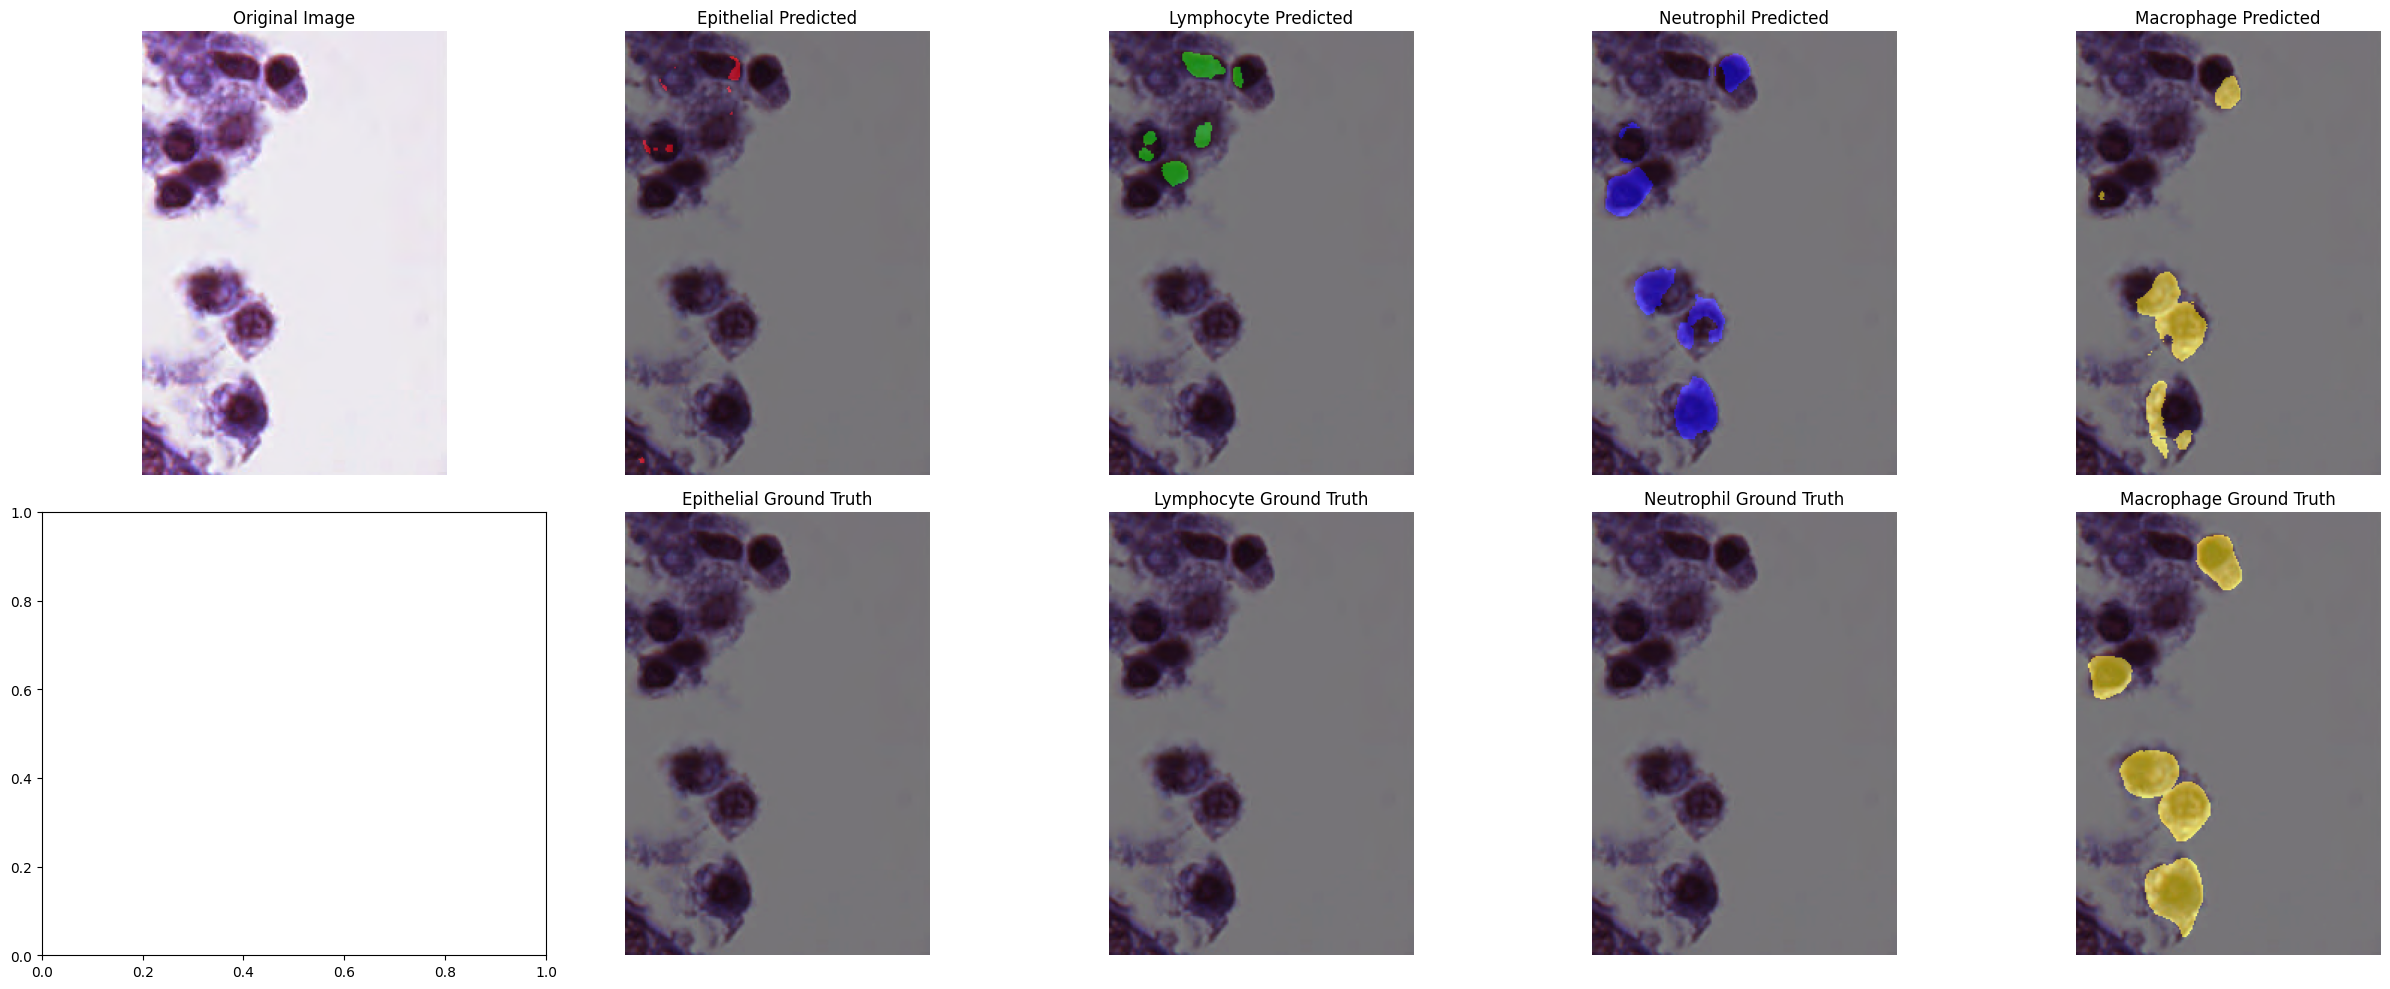

In [ ]:
# Load the ground truth CSV (if not already loaded)
if 'ground_truth_df' not in locals():
    raise Exception("Ground truth DataFrame not loaded. Run the cell above first.")

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Define the path to slide1.tif
slide1_path = TRAIN_DIR / "slide1.tif"

# Use the analyze_and_visualize_masks function
analyze_and_visualize_masks(slide1_path, model, ground_truth_df)

In [ ]:
print("\nGenerating predictions...")
submission_df = predict_test_set(model, TEST_DIR, DEVICE)

# Extract the number at the end of image_id coulmn
submission_df['slide_num'] = submission_df['image_id'].str.extract(r'(\d+)$')
submission_df['slide_num'] = submission_df['slide_num'].astype(int)

# Set slide number as index column and sort by it
submission_df.set_index('slide_num', inplace=True)
submission_df.sort_index(inplace=True)

submission_df.to_csv('submission.csv', index=False)
print(f"\n✅ Submission saved: submission.csv")
print(f"Shape: {submission_df.shape}")
print("\nSample rows:")
submission_df.head()


Generating predictions...

Predicting on 40 test images...


100%|██████████| 40/40 [00:03<00:00, 12.24it/s]



✅ Submission saved: submission.csv
Shape: (40, 5)

Sample rows:


,image_id,Epithelial,Lymphocyte,Neutrophil,Macrophage
slide_num,,,,,
1,slide1,3 17920 4 3 18076 10 3 18233 11 15 18344 2 3 1...,1 31278 4 1 31433 7 1 31589 8 1 31745 10 1 319...,2 13135 3 2 13291 6 2 13447 7 2 13604 7 2 1376...,1 2010 5 1 2165 9 1 2319 13 1 2474 17 1 2629 2...
2,slide2,4 2020 16 10 2682 13 4 2969 17 10 3630 16 4 39...,62 2112 2 83 2146 4 97 2175 15 125 2255 7 62 3...,0,0
3,slide3,2 16490 2 2 17054 6 2 17620 8 2 18187 8 2 1875...,224 2642 5 264 2767 5 193 3172 3 224 3206 10 2...,15 132013 1 14 132016 2 14 132583 2 14 133150 ...,0
4,slide4,1 16187 1,0,1 2192 1 1 2197 2 1 2321 18 1 2453 23 1 2586 2...,2 11622 3 2 11756 3 1 12017 5 1 12151 5 1 12286 3
5,slide5,265 22589 9 97 24057 7 265 24735 16 109 26260 ...,69 22707 1 105 23378 5 69 24856 5 105 25526 11...,10 331917 2 10 334065 9 10 336216 6 13 673908 ...,0


In [ ]:
!ls -lh


total 1.9G
-rw-r--r-- 1 root root 263M Oct 28 03:01 best_model.pth
-rw-r--r-- 1 root root 312M Oct 18 00:23 cell-segmentation-cs-gy-6643.zip
drwxr-xr-x 4 root root 4.0K Oct 28 01:15 data_folder
-rw-r--r-- 1 root root 263M Oct 28 01:38 fold_1_model.pth
-rw-r--r-- 1 root root 263M Oct 28 02:00 fold_2_model.pth
-rw-r--r-- 1 root root 263M Oct 28 02:21 fold_3_model.pth
-rw-r--r-- 1 root root 263M Oct 28 02:43 fold_4_model.pth
-rw-r--r-- 1 root root 263M Oct 28 03:03 fold_5_model.pth
drwxr-xr-x 1 root root 4.0K Oct 24 13:37 sample_data


In [ ]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>